In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
data1 = pd.read_csv('../data/chisato/goal/log201805261417.csv',header=None)
data2 = pd.read_csv('../data/chisato/goal/log201805261602.csv',header=None)
data3 = pd.read_csv('../data/chisato/goal/log201805261614.csv',header=None)
d = pd.concat([pd.concat([data1,data2]),data3])
#print(ball)
#print(joy)

In [3]:
d.columns = ['bx','by','jx','jy']
d = d[d.bx!=-1]

In [4]:
'''
from sklearn.cross_validation import train_test_split
t1 = []
t2 = []
def f1(x,y):
    return y * np.sin(x) + np.square(x)
def f2(x,y):
    return x * np.cos(y) + np.square(y)
for a in range(1000):
    r = np.array([np.random.rand(), np.random.rand()])
    t1.append(r)
    t2.append(np.array([ f1(r[0],r[1]),f2(r[0],r[1]) ]))
IN_train, IN_test, TAR_train, TAR_test = train_test_split(t1,t2,test_size=0.2,random_state=0)

IN_train = np.array(IN_train)
IN_test = np.array(IN_test)
TAR_train = np.array(TAR_train)
TAR_test = np.array(TAR_test)
print(IN_train[0])
print(IN_test[0])
print(TAR_train[0])
print(TAR_test[0])
print(f1(1,1))
print(f2(1,1))
'''

'\nfrom sklearn.cross_validation import train_test_split\nt1 = []\nt2 = []\ndef f1(x,y):\n    return y * np.sin(x) + np.square(x)\ndef f2(x,y):\n    return x * np.cos(y) + np.square(y)\nfor a in range(1000):\n    r = np.array([np.random.rand(), np.random.rand()])\n    t1.append(r)\n    t2.append(np.array([ f1(r[0],r[1]),f2(r[0],r[1]) ]))\nIN_train, IN_test, TAR_train, TAR_test = train_test_split(t1,t2,test_size=0.2,random_state=0)\n\nIN_train = np.array(IN_train)\nIN_test = np.array(IN_test)\nTAR_train = np.array(TAR_train)\nTAR_test = np.array(TAR_test)\nprint(IN_train[0])\nprint(IN_test[0])\nprint(TAR_train[0])\nprint(TAR_test[0])\nprint(f1(1,1))\nprint(f2(1,1))\n'

In [5]:
from sklearn.cross_validation import train_test_split
ball = np.array(d.iloc[:,0:2])
joy = np.array(d.iloc[:,2:4])
IN_train, IN_test, TAR_train, TAR_test = train_test_split(ball,joy,test_size=0.2,random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
IN_train = IN_train/100.0
IN_test = IN_test/100.0
print(IN_train[0])
print(IN_test[0])
print(TAR_train[0])
print(TAR_test[0])

[ 2.77322845  0.58032635]
[ 3.87715881 -1.19988327]
[-0.03094482 -1.        ]
[ 0.99996948 -0.53610229]


In [6]:
#　初期化
sess = tf.Session()
seed = 3
#tf.set_random_seed(seed)
#np.random.seed(seed)
IN_size = 2
TAR_size = 2
INPUT = tf.placeholder(shape=[None, IN_size], dtype=tf.float32)
TARGET = tf.placeholder(shape=[None, TAR_size], dtype=tf.float32)

In [7]:
hidden_size = [25, 3]
batch_size = 100
iter_size = 50000

#　隠れ層の作成 （last layerに直結）
weights = []
biases = []
layers = []
tmp_size = IN_size
last_layer = INPUT
for hsize in hidden_size:
    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize], stddev=10.0)))
    biases.append(tf.Variable(tf.random_normal(shape=[hsize], stddev=10.0)))
    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数
    tmp_size = hsize
    last_layer = layers[-1]
    print(layers[-1])
#　出力層
weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, TAR_size], stddev=10.0)))
biases.append(tf.Variable(tf.random_normal(shape=[TAR_size], stddev=10.0)))
layers.append(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))
final_output = layers[-1]
print(final_output)

Tensor("Relu:0", shape=(?, 25), dtype=float32)
Tensor("Relu_1:0", shape=(?, 3), dtype=float32)
Tensor("Add_2:0", shape=(?, 2), dtype=float32)


In [8]:
#　学習
loss = tf.losses.mean_squared_error(TARGET,final_output)
opt = tf.train.AdamOptimizer(0.001)
train_step = opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)
loss_vec=[]
for i in range(iter_size):
    rand_index = np.random.choice(len(IN_train), size=batch_size)
    rand_in = IN_train[rand_index]
    rand_tar = TAR_train[rand_index]
    sess.run(train_step, feed_dict={INPUT:rand_in, TARGET: rand_tar})
    loss_vec.append(sess.run(loss, feed_dict={INPUT:rand_in, TARGET: rand_tar}))
    if (i+1)%25==0:
#        print(sess.run(INPUT, feed_dict={INPUT:rand_in, TARGET: rand_tar}))
        print('Generation:'+str(i+1)+', Loss = '+str(loss_vec[-1]))

Generation:25, Loss = 1.23765e+08
Generation:50, Loss = 1.00888e+08
Generation:75, Loss = 8.42346e+07
Generation:100, Loss = 1.08734e+08
Generation:125, Loss = 8.3451e+07
Generation:150, Loss = 9.0305e+07
Generation:175, Loss = 9.15266e+07
Generation:200, Loss = 6.46121e+07
Generation:225, Loss = 7.87583e+07
Generation:250, Loss = 6.77892e+07
Generation:275, Loss = 7.55657e+07
Generation:300, Loss = 6.66228e+07
Generation:325, Loss = 6.46402e+07
Generation:350, Loss = 5.78768e+07
Generation:375, Loss = 5.60292e+07
Generation:400, Loss = 5.94706e+07
Generation:425, Loss = 5.66707e+07
Generation:450, Loss = 5.34006e+07
Generation:475, Loss = 4.28647e+07
Generation:500, Loss = 4.82789e+07
Generation:525, Loss = 4.60296e+07
Generation:550, Loss = 3.58787e+07
Generation:575, Loss = 3.80089e+07
Generation:600, Loss = 4.19298e+07
Generation:625, Loss = 3.79254e+07
Generation:650, Loss = 4.19567e+07
Generation:675, Loss = 3.09794e+07
Generation:700, Loss = 2.87388e+07
Generation:725, Loss = 2.

Generation:6025, Loss = 124800.0
Generation:6050, Loss = 135090.0
Generation:6075, Loss = 156786.0
Generation:6100, Loss = 146791.0
Generation:6125, Loss = 126269.0
Generation:6150, Loss = 137521.0
Generation:6175, Loss = 152085.0
Generation:6200, Loss = 133663.0
Generation:6225, Loss = 118985.0
Generation:6250, Loss = 108512.0
Generation:6275, Loss = 141068.0
Generation:6300, Loss = 125919.0
Generation:6325, Loss = 121215.0
Generation:6350, Loss = 84074.9
Generation:6375, Loss = 93998.5
Generation:6400, Loss = 108755.0
Generation:6425, Loss = 110136.0
Generation:6450, Loss = 109526.0
Generation:6475, Loss = 93763.9
Generation:6500, Loss = 130922.0
Generation:6525, Loss = 92619.5
Generation:6550, Loss = 88709.7
Generation:6575, Loss = 105613.0
Generation:6600, Loss = 122213.0
Generation:6625, Loss = 92701.6
Generation:6650, Loss = 105600.0
Generation:6675, Loss = 101889.0
Generation:6700, Loss = 104236.0
Generation:6725, Loss = 110528.0
Generation:6750, Loss = 93079.4
Generation:6775, 

Generation:12375, Loss = 1925.93
Generation:12400, Loss = 1895.56
Generation:12425, Loss = 1857.71
Generation:12450, Loss = 1690.9
Generation:12475, Loss = 2132.49
Generation:12500, Loss = 2502.22
Generation:12525, Loss = 1906.01
Generation:12550, Loss = 1723.02
Generation:12575, Loss = 1670.89
Generation:12600, Loss = 1751.52
Generation:12625, Loss = 1597.06
Generation:12650, Loss = 1255.74
Generation:12675, Loss = 1651.04
Generation:12700, Loss = 1478.34
Generation:12725, Loss = 1503.33
Generation:12750, Loss = 1376.72
Generation:12775, Loss = 1316.78
Generation:12800, Loss = 1067.56
Generation:12825, Loss = 1557.19
Generation:12850, Loss = 1376.22
Generation:12875, Loss = 1267.54
Generation:12900, Loss = 964.511
Generation:12925, Loss = 793.622
Generation:12950, Loss = 885.323
Generation:12975, Loss = 1526.02
Generation:13000, Loss = 868.824
Generation:13025, Loss = 1220.46
Generation:13050, Loss = 1617.8
Generation:13075, Loss = 961.597
Generation:13100, Loss = 1305.35
Generation:1

Generation:18600, Loss = 2.14716
Generation:18625, Loss = 3.56015
Generation:18650, Loss = 20.1078
Generation:18675, Loss = 6.80891
Generation:18700, Loss = 8.05217
Generation:18725, Loss = 7.33177
Generation:18750, Loss = 0.945517
Generation:18775, Loss = 6.47423
Generation:18800, Loss = 6.13709
Generation:18825, Loss = 0.753419
Generation:18850, Loss = 4.19615
Generation:18875, Loss = 4.17451
Generation:18900, Loss = 2.52952
Generation:18925, Loss = 2.69923
Generation:18950, Loss = 3.73833
Generation:18975, Loss = 4.4882
Generation:19000, Loss = 7.37176
Generation:19025, Loss = 3.54691
Generation:19050, Loss = 2.79438
Generation:19075, Loss = 7.43824
Generation:19100, Loss = 2.89474
Generation:19125, Loss = 3.24332
Generation:19150, Loss = 2.45595
Generation:19175, Loss = 3.97087
Generation:19200, Loss = 1.23991
Generation:19225, Loss = 4.05713
Generation:19250, Loss = 2.03322
Generation:19275, Loss = 2.97084
Generation:19300, Loss = 2.42946
Generation:19325, Loss = 3.34795
Generatio

Generation:24775, Loss = 0.124448
Generation:24800, Loss = 0.209529
Generation:24825, Loss = 0.209512
Generation:24850, Loss = 0.250235
Generation:24875, Loss = 0.298663
Generation:24900, Loss = 0.208079
Generation:24925, Loss = 0.268087
Generation:24950, Loss = 0.123313
Generation:24975, Loss = 0.811992
Generation:25000, Loss = 0.853983
Generation:25025, Loss = 0.236668
Generation:25050, Loss = 0.431008
Generation:25075, Loss = 0.169981
Generation:25100, Loss = 0.135942
Generation:25125, Loss = 0.329301
Generation:25150, Loss = 0.208833
Generation:25175, Loss = 0.223801
Generation:25200, Loss = 0.192852
Generation:25225, Loss = 0.157808
Generation:25250, Loss = 0.142085
Generation:25275, Loss = 0.181834
Generation:25300, Loss = 0.643998
Generation:25325, Loss = 0.123658
Generation:25350, Loss = 0.161407
Generation:25375, Loss = 0.174849
Generation:25400, Loss = 0.19759
Generation:25425, Loss = 0.186451
Generation:25450, Loss = 0.147641
Generation:25475, Loss = 0.143862
Generation:2550

Generation:30825, Loss = 0.0901403
Generation:30850, Loss = 0.100074
Generation:30875, Loss = 0.143094
Generation:30900, Loss = 0.190471
Generation:30925, Loss = 0.100398
Generation:30950, Loss = 0.204724
Generation:30975, Loss = 0.126373
Generation:31000, Loss = 0.129129
Generation:31025, Loss = 0.233201
Generation:31050, Loss = 0.120642
Generation:31075, Loss = 0.0907103
Generation:31100, Loss = 0.102655
Generation:31125, Loss = 0.331779
Generation:31150, Loss = 0.264707
Generation:31175, Loss = 0.188529
Generation:31200, Loss = 0.133474
Generation:31225, Loss = 0.143267
Generation:31250, Loss = 0.124549
Generation:31275, Loss = 0.15981
Generation:31300, Loss = 0.287812
Generation:31325, Loss = 0.101847
Generation:31350, Loss = 0.139326
Generation:31375, Loss = 0.218285
Generation:31400, Loss = 0.136396
Generation:31425, Loss = 0.104297
Generation:31450, Loss = 0.152996
Generation:31475, Loss = 0.122415
Generation:31500, Loss = 0.130636
Generation:31525, Loss = 0.169308
Generation:31

Generation:36850, Loss = 0.0966172
Generation:36875, Loss = 0.0888784
Generation:36900, Loss = 0.107042
Generation:36925, Loss = 0.0872828
Generation:36950, Loss = 0.102456
Generation:36975, Loss = 0.0958768
Generation:37000, Loss = 0.0999962
Generation:37025, Loss = 0.100315
Generation:37050, Loss = 0.0918321
Generation:37075, Loss = 0.165626
Generation:37100, Loss = 0.212025
Generation:37125, Loss = 0.193668
Generation:37150, Loss = 0.299861
Generation:37175, Loss = 0.275377
Generation:37200, Loss = 0.116086
Generation:37225, Loss = 0.251649
Generation:37250, Loss = 0.0895954
Generation:37275, Loss = 0.245651
Generation:37300, Loss = 0.122328
Generation:37325, Loss = 0.247242
Generation:37350, Loss = 0.0946971
Generation:37375, Loss = 0.136156
Generation:37400, Loss = 0.215036
Generation:37425, Loss = 0.260423
Generation:37450, Loss = 0.101841
Generation:37475, Loss = 0.144682
Generation:37500, Loss = 0.208963
Generation:37525, Loss = 0.0938759
Generation:37550, Loss = 0.116406
Gener

Generation:42850, Loss = 0.0937804
Generation:42875, Loss = 0.14591
Generation:42900, Loss = 0.227805
Generation:42925, Loss = 0.111184
Generation:42950, Loss = 0.195823
Generation:42975, Loss = 0.104942
Generation:43000, Loss = 0.21291
Generation:43025, Loss = 0.11227
Generation:43050, Loss = 0.0908637
Generation:43075, Loss = 0.0979315
Generation:43100, Loss = 0.101886
Generation:43125, Loss = 0.0903865
Generation:43150, Loss = 0.502516
Generation:43175, Loss = 0.093965
Generation:43200, Loss = 0.348474
Generation:43225, Loss = 0.0847185
Generation:43250, Loss = 0.272549
Generation:43275, Loss = 0.16111
Generation:43300, Loss = 0.147049
Generation:43325, Loss = 0.103742
Generation:43350, Loss = 0.161101
Generation:43375, Loss = 0.131391
Generation:43400, Loss = 0.150524
Generation:43425, Loss = 0.211755
Generation:43450, Loss = 0.247637
Generation:43475, Loss = 0.177915
Generation:43500, Loss = 0.0993697
Generation:43525, Loss = 0.139132
Generation:43550, Loss = 0.169964
Generation:4

Generation:48925, Loss = 0.0831823
Generation:48950, Loss = 0.0766934
Generation:48975, Loss = 0.108013
Generation:49000, Loss = 0.0922846
Generation:49025, Loss = 0.125158
Generation:49050, Loss = 0.127921
Generation:49075, Loss = 0.334892
Generation:49100, Loss = 0.0915612
Generation:49125, Loss = 0.19613
Generation:49150, Loss = 0.083319
Generation:49175, Loss = 0.0756316
Generation:49200, Loss = 0.380935
Generation:49225, Loss = 0.252046
Generation:49250, Loss = 0.0993869
Generation:49275, Loss = 0.0996242
Generation:49300, Loss = 0.0902487
Generation:49325, Loss = 0.109524
Generation:49350, Loss = 0.0875333
Generation:49375, Loss = 0.098993
Generation:49400, Loss = 0.114685
Generation:49425, Loss = 0.407827
Generation:49450, Loss = 0.294805
Generation:49475, Loss = 0.0956723
Generation:49500, Loss = 0.242815
Generation:49525, Loss = 0.0999155
Generation:49550, Loss = 0.103254
Generation:49575, Loss = 0.276831
Generation:49600, Loss = 0.396504
Generation:49625, Loss = 0.423877
Gene

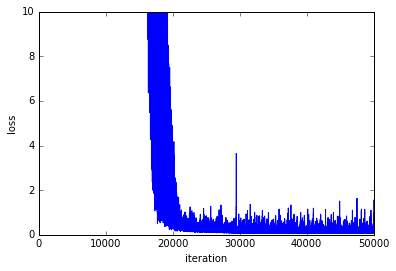

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(loss_vec)
#plt.xlim(0,25)
plt.ylim(0,10)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
plt.savefig(str(hidden_size)+'.png')

In [ ]:
# predict
sample = np.array([[ 5, -0.8]])
p = sess.run(final_output, feed_dict={INPUT: sample})
print(p)

In [49]:
sam_y = np.array(range(-10,11))
for i in range(len(sam_y)):
    sample = np.array([[5.0, sam_y[i]/10.0]])
    print(sample)
    p = sess.run(final_output, feed_dict={INPUT: sample})
    print(p)

[[ 5. -1.]]
[[-0.51380539 -2.04456067]]
[[ 5.  -0.9]]
[[-0.59627295 -2.08707929]]
[[ 5.  -0.8]]
[[-0.67761087 -2.12914586]]
[[ 5.  -0.7]]
[[-0.75760555 -2.16949725]]
[[ 5.  -0.6]]
[[-0.83967686 -2.21167397]]
[[ 5.  -0.5]]
[[-0.92046499 -2.2531054 ]]
[[ 5.  -0.4]]
[[-1.0007658  -2.29322553]]
[[ 5.  -0.3]]
[[-1.0822258  -2.33523107]]
[[ 5.  -0.2]]
[[-1.16405249 -2.3772366 ]]
[[ 5.  -0.1]]
[[-1.24401712 -2.4177773 ]]
[[ 5.  0.]]
[[-1.32505035 -2.4588306 ]]
[[ 5.   0.1]]
[[-1.40660238 -2.5009644 ]]
[[ 5.   0.2]]
[[-1.48754358 -2.54199338]]
[[ 5.   0.3]]
[[-1.56857586 -2.58336425]]
[[ 5.   0.4]]
[[-1.64912128 -2.62354493]]
[[ 5.   0.5]]
[[-1.7297883  -2.66411042]]
[[ 5.   0.6]]
[[-1.81216431 -2.70772719]]
[[ 5.   0.7]]
[[-1.89380693 -2.74964738]]
[[ 5.   0.8]]
[[-1.97380257 -2.79010892]]
[[ 5.   0.9]]
[[-2.05529356 -2.83171153]]
[[ 5.  1.]]
[[-2.13687563 -2.8737781 ]]
